In [ ]:
#Bloque 0
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print("TF version:", tf.__version__)
print("GPU:", gpus)


TF version: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#Bloque 1
!pip -q install opencv-python-headless==4.10.0.84

#Bloque 2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os

print("TF version:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))
# No vuelvas a llamar set_memory_growth aquí


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.7 MB/s eta 0:00:00
TF version: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#Bloque 3
from google.colab import drive
drive.mount('/content/drive')

BASE_DATA   = "/content/drive/MyDrive/Modelo_entrenamiento"
DATA_COLORS  = BASE_DATA + "/Colores_entrenamiento"
DATA_LETTERS = BASE_DATA + "/Letras_entrenamiento"

# Tamaños ligeros para bajar memoria
IMG_SIZE = (16, 16)
BATCH    = 16
SEED     = 1337
AUTOTUNE = tf.data.AUTOTUNE

# Carpeta de backups (reanuda entrenamiento si se cierra la sesión)
BK_DIR_BASE     = "/content/drive/MyDrive/_bk_train"
BK_DIR_COLORS   = os.path.join(BK_DIR_BASE, "colors")
BK_DIR_LETTERS  = os.path.join(BK_DIR_BASE, "letters")
os.makedirs(BK_DIR_COLORS,  exist_ok=True)
os.makedirs(BK_DIR_LETTERS, exist_ok=True)
# 🔹 Identificador único de corrida para evitar colisiones en caché de disco
import uuid
RUN_TAG = uuid.uuid4().hex[:8]



Mounted at /content/drive


In [ ]:
#Parche
#Bloque 4 Preprocesamiento y construcción de datasets (colores & letras) ===
import cv2
cv2.setNumThreads(0)  # ← evita deadlocks raros con tf.data + py_function + OpenCV
import numpy as np
from pathlib import Path
# tf, keras, layers ya están importados en bloques previos

# ---------- Utilidades de recorte comunes ----------
def _central_square_crop_bgr(bgr):
    h, w = bgr.shape[:2]
    side = min(h, w)
    off_h = (h - side) // 2
    off_w = (w - side) // 2
    return bgr[off_h:off_h+side, off_w:off_w+side]

# ---------- COLORES: recorte por cuadrilátero grande ----------
def _find_largest_quad_roi_bgr(bgr, min_area_ratio=0.02):
    H, W = bgr.shape[:2]
    min_area = H * W * float(min_area_ratio)

    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g, (5,5), 0)
    edges = cv2.Canny(g, 60, 180)

    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best = None
    best_area = 0.0

    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area:
            continue
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.03 * peri, True)
        if len(approx) == 4 and area > best_area:
            best = approx
            best_area = area

    if best is None and len(cnts) > 0:
        c = max(cnts, key=cv2.contourArea)
        if cv2.contourArea(c) >= min_area:
            best = cv2.approxPolyDP(c, 0.03 * cv2.arcLength(c, True), True)

    if best is None:
        return _central_square_crop_bgr(bgr)

    x, y, w, h = cv2.boundingRect(best)
    roi = bgr[y:y+h, x:x+w]
    roi = cv2.medianBlur(roi, 3)
    return roi

# ---------- Helper robusto para decodificar rutas desde tf.py_function ----------
def _decode_path(p):
    # p puede ser bytes o un tf.Tensor (EagerTensor) de dtype string
    if isinstance(p, (bytes, bytearray)):
        return p.decode("utf-8")
    try:
        return p.numpy().decode("utf-8")
    except AttributeError:
        # fallback por si llega en otro tipo
        return str(p)

def _load_and_crop_bgr_numpy(path_tensor):
    path = _decode_path(path_tensor)
    bgr  = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"No se pudo leer: {path}")
    roi_bgr = _find_largest_quad_roi_bgr(bgr)
    rgb = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2RGB).astype(np.uint8)
    return rgb

def load_and_preprocess_with_square(path, to_gray=False):
    # OpenCV dentro de py_function; luego resize/normaliza en TF
    rgb = tf.py_function(func=_load_and_crop_bgr_numpy, inp=[path], Tout=tf.uint8)
    rgb.set_shape([None, None, 3])
    x = tf.image.resize(tf.cast(rgb, tf.float32) / 255.0, IMG_SIZE)
    if to_gray:
        x = tf.image.rgb_to_grayscale(x)
    return x

# ---------- LETRAS: recorte por componente conectado principal ----------
def _find_letter_roi_bgr(bgr, min_area=800):
    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g, (3,3), 0)
    thr = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 21, 5)
    cnts, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return _central_square_crop_bgr(bgr)
    c = max(cnts, key=cv2.contourArea)
    if cv2.contourArea(c) < min_area:
        return _central_square_crop_bgr(bgr)
    x, y, w, h = cv2.boundingRect(c)
    roi = bgr[y:y+h, x:x+w]
    roi = cv2.medianBlur(roi, 3)
    return roi
#parche
def _load_and_crop_letters_numpy(path_tensor):
    path = _decode_path(path_tensor)
    bgr  = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"No se pudo leer: {path}")
    roi_bgr = _find_letter_roi_bgr(bgr)
    rgb = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2RGB).astype(np.uint8)
    return rgb

#Parche
def load_and_preprocess_letters(path, img_size=(32,32)):
    rgb = tf.py_function(func=_load_and_crop_letters_numpy, inp=[path], Tout=tf.uint8)
    rgb.set_shape([None, None, 3])
    x = tf.image.rgb_to_grayscale(rgb)
    x = tf.image.resize(tf.cast(x, tf.float32) / 255.0, img_size)
    x.set_shape((img_size[0], img_size[1], 1))  # (32,32,1)
    return x

# ---------- Listado y splits ----------
def list_files_and_labels(root_dir):
    root = Path(root_dir)
    class_names = sorted([p.name for p in root.iterdir() if p.is_dir()])
    name_to_idx = {n: i for i, n in enumerate(class_names)}
    files, labels = [], []
    for n in class_names:
        for p in (root / n).glob("*"):
            if p.is_file():
                files.append(str(p))
                labels.append(name_to_idx[n])
    return np.array(files), np.array(labels), class_names

def stratified_split(files, labels, val_ratio=0.2, seed=SEED):
    rng = np.random.RandomState(seed)
    tr_files, tr_labels, va_files, va_labels = [], [], [], []
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        rng.shuffle(idx)
        k = int(len(idx) * val_ratio)
        va_idx, tr_idx = idx[:k], idx[k:]
        tr_files += list(files[tr_idx]); tr_labels += list(labels[tr_idx])
        va_files += list(files[va_idx]); va_labels += list(labels[va_idx])
    return np.array(tr_files), np.array(tr_labels), np.array(va_files), np.array(va_labels)

# ---------- Constructor del dataset (task-aware + cache por split) ----------
#parche
# --- make_ds corregido (indentación y 32x32 para letras) ---
def make_ds(files, labels, num_classes, task="colors", augment=False, shuffle=True, cache_tag="train"):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))

    def _map_colors(path, y):
        x = load_and_preprocess_with_square(path, to_gray=False)
        y = tf.one_hot(y, num_classes)
        return x, y

    def _map_letters(path, y):
        x = load_and_preprocess_letters(path, img_size=(32, 32))
        y = tf.one_hot(y, num_classes)
        return x, y

    mapper = _map_colors if task == "colors" else _map_letters

    # COLORES: AUTOTUNE; LETRAS: 1 hilo (más estable)
    npc = AUTOTUNE if task == "colors" else 1
    ds = ds.map(mapper, num_parallel_calls=npc)

    # Cache híbrido (train→disco con RUN_TAG; val/test→memoria)
    if cache_tag == "train":
        cache_path = f"/content/cache_{task}_{cache_tag}_{RUN_TAG}"
        ds = ds.cache(cache_path)
    else:
        ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)

    if augment:
        if task == "colors":
            aug = keras.Sequential([
                layers.RandomRotation(0.03),
                layers.RandomZoom(0.08),
                layers.RandomTranslation(0.05, 0.05),
            ])
        else:
            aug = keras.Sequential([
                layers.RandomRotation(0.03),
                layers.RandomTranslation(0.05, 0.05),
            ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=npc)

    ds = ds.batch(BATCH).prefetch(AUTOTUNE)

    opts = tf.data.Options()
    # opts.experimental_deterministic = True  # opcional, explícito
    ds = ds.with_options(opts)
    return ds


In [ ]:
#BLOQUE 5
import os, subprocess

LOCAL_BASE = "/content/_data"
LOCAL_COLORS  = f"{LOCAL_BASE}/Colores_entrenamiento"
LOCAL_LETTERS = f"{LOCAL_BASE}/Letras_entrenamiento"
os.makedirs(LOCAL_BASE, exist_ok=True)

def rsync_dir(src, dst):
    subprocess.run(["rsync","-ah","--delete", src+"/", dst+"/"], check=True)

# Copia desde Drive → disco local (mucho más rápido por época)
rsync_dir(DATA_COLORS,  LOCAL_COLORS)
rsync_dir(DATA_LETTERS, LOCAL_LETTERS)

# Reapunta
DATA_COLORS  = LOCAL_COLORS
DATA_LETTERS = LOCAL_LETTERS

print("Datasets copiados a /content/")



Datasets copiados a /content/


In [ ]:
#BLOQUE 6
# === Limpieza de cachés viejos (lockfiles + dirs) ===
import os, shutil, glob

# 1) Elimina lockfiles sueltos del cache de tf.data
for f in glob.glob("/content/cache_*lockfile*"):
    try:
        os.remove(f)
        print("🗑️  Eliminado lockfile:", f)
    except FileNotFoundError:
        pass

# 2) Elimina directorios de cache (de corridas previas)
for d in ["/content/cache_colors_train",
          "/content/cache_colors_val",
          "/content/cache_letters_train",
          "/content/cache_letters_val"]:
    if os.path.exists(d):
        shutil.rmtree(d, ignore_errors=True)
        print("🧹 Eliminado dir de cache:", d)

print("Caches eliminados ✅")


Caches eliminados ✅


In [ ]:
#BLOQUE 7
# === BLOQUE 7 (nuevo) ===
# Limpieza amplia de cualquier cache_* en /content (carpetas o lockfiles)
import glob, shutil, os

for d in glob.glob("/content/cache_*"):
    try:
        if os.path.isdir(d):
            shutil.rmtree(d, ignore_errors=True)
            print("🧹 Eliminado dir:", d)
        elif os.path.isfile(d):
            os.remove(d)
            print("🗑️  Eliminado archivo:", d)
    except Exception as e:
        print("⚠️ No se pudo borrar", d, "->", e)

print("Caches eliminados ✅")




Caches eliminados ✅


In [ ]:
# === BLOQUE 8  Construcción de datasets de COLORES ===
files_c, labels_c, C_NAMES = list_files_and_labels(DATA_COLORS)

tr_c, trl_c, va_c, val_c = stratified_split(files_c, labels_c, val_ratio=0.25, seed=SEED)

train_c = make_ds(tr_c, trl_c, len(C_NAMES),
                  task="colors", augment=True, shuffle=True, cache_tag="train")

val_c   = make_ds(va_c, val_c, len(C_NAMES),
                  task="colors", augment=False, shuffle=False, cache_tag="val")



In [ ]:
#BLOQUE 9— Construcción de datasets de LETRAS ===
files_l, labels_l, L_NAMES = list_files_and_labels(DATA_LETTERS)

tr_l, trl_l, va_l, val_l = stratified_split(files_l, labels_l, val_ratio=0.25, seed=SEED)

train_l = make_ds(tr_l, trl_l, len(L_NAMES),
                  task="letters", augment=True, shuffle=True, cache_tag="train")

val_l   = make_ds(va_l, val_l, len(L_NAMES),
                  task="letters", augment=False, shuffle=False, cache_tag="val")


In [ ]:
#BLOQUE 10
import tensorflow as tf
tf.keras.backend.clear_session()

def make_tiny_cnn(num_classes, input_shape):
    """Modelo pequeño mejorado para Colores"""
    inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inp, out)

def make_stronger_cnn(num_classes, input_shape):
    """Modelo más fuerte mejorado para Letras"""
    inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)   # capa extra más fuerte
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inp, out)

# === Modelos ===
# Colores usa IMG_SIZE original
model_colors  = make_tiny_cnn(len(C_NAMES),  IMG_SIZE + (3,))

# Letras usa input fijo (32,32,1)
model_letters = make_stronger_cnn(len(L_NAMES), (32,32,1))

# === Optimizadores separados ===
opt_colors  = keras.optimizers.Adam(learning_rate=0.001)
opt_letters = keras.optimizers.Adam(learning_rate=0.001)

# Compilación (colores normal, letras en eager si lo necesitas)
model_colors.compile(optimizer=opt_colors,  loss="categorical_crossentropy", metrics=["accuracy"])
model_letters.compile(optimizer=opt_letters, loss="categorical_crossentropy", metrics=["accuracy"], run_eagerly=True)




In [ ]:

#BLOQUE 11
import time

class EpochTimer(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.t0 = time.perf_counter()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.perf_counter() - self.t0
        self.epoch_times.append(dt)
        avg = sum(self.epoch_times)/len(self.epoch_times)
        rem = (self.total_epochs-(epoch+1))*avg
        print(f"⏱️ Epoch {epoch+1}/{self.total_epochs} duró {dt:.2f}s, prom {avg:.2f}s, ETA ≈ {rem/60:.1f} min")

def make_cbs(best_path, epochs, backup_dir, log_path_csv):
    return [
        keras.callbacks.ModelCheckpoint(best_path, save_best_only=True,
                                        monitor="val_accuracy", mode="max", verbose=1),
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True,
                                      monitor="val_accuracy", mode="max", verbose=1),
        keras.callbacks.CSVLogger(log_path_csv, append=True),
        keras.callbacks.BackupAndRestore(backup_dir=backup_dir),
        EpochTimer(epochs)
    ]


In [ ]:
#BLOQUE 12
# === Bloque previo al entrenamiento (crear carpetas de backup) ===
os.makedirs(BK_DIR_COLORS, exist_ok=True)
os.makedirs(BK_DIR_LETTERS, exist_ok=True)



In [ ]:
#parche
#BLOQUE 13
EPOCHS = 60  # subimos un poco para aprovechar el LR scheduler

BEST_COLORS_PATH   = "best_colors.keras"
BEST_LETTERS_PATH  = "best_letters.keras"

# Rutas en Drive (persistencia final)
LOG_COLORS_CSV     = os.path.join(BK_DIR_COLORS,  "train_log.csv")
LOG_LETTERS_CSV    = os.path.join(BK_DIR_LETTERS, "train_log.csv")

# Rutas locales (rápidas) para evitar cuelgues de Drive durante el fit
LOG_COLORS_CSV_LOCAL  = "/content/train_colors.csv"
LOG_LETTERS_CSV_LOCAL = "/content/train_letters.csv"

def make_cbs(best_path, epochs, bk_dir, log_csv_local):
    return [
        keras.callbacks.ModelCheckpoint(best_path, save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.CSVLogger(log_csv_local, append=True),  # ← LOG LOCAL
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ]

print("=== Entrenando COLORES ===")
hist_c = model_colors.fit(
    train_c, validation_data=val_c, epochs=EPOCHS,
    callbacks=make_cbs(BEST_COLORS_PATH, EPOCHS, BK_DIR_COLORS, LOG_COLORS_CSV_LOCAL)
)

print("\n=== Entrenando LETRAS ===")
hist_l = model_letters.fit(
    train_l, validation_data=val_l, epochs=EPOCHS,
    callbacks=make_cbs(BEST_LETTERS_PATH, EPOCHS, BK_DIR_LETTERS, LOG_LETTERS_CSV_LOCAL)
)

# Copia de logs locales → Drive (persistencia)
import shutil
shutil.copyfile(LOG_COLORS_CSV_LOCAL,  LOG_COLORS_CSV)
shutil.copyfile(LOG_LETTERS_CSV_LOCAL, LOG_LETTERS_CSV)
print("📁 Logs copiados a Drive:", LOG_COLORS_CSV, LOG_LETTERS_CSV)



=== Entrenando COLORES ===
Epoch 1/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9672 - loss: 0.1046 - val_accuracy: 0.9513 - val_loss: 0.1216 - learning_rate: 1.0000e-06
Epoch 2/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9479 - loss: 0.1316 - val_accuracy: 0.9513 - val_loss: 0.1220 - learning_rate: 1.0000e-06
Epoch 3/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9693 - loss: 0.1076 - val_accuracy: 0.9513 - val_loss: 0.1222 - learning_rate: 1.0000e-06
Epoch 4/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9663 - loss: 0.1142 - val_accuracy: 0.9513 - val_loss: 0.1222 - learning_rate: 1.0000e-06
Epoch 5/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9675 - loss: 0.0891 - val_accuracy: 0.9513 - val_loss: 0.1220 - learning_rate: 1.0000e-06
Epoch 6/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9515 - loss: 0.1186 - val_accuracy: 0.9513 - val_loss: 0.1219 - learning_rate: 1.0000e-06
Epoch 7/60
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14

In [ ]:
#BLOQUE 14
from sklearn.metrics import classification_report, confusion_matrix

def eval_model(model, val_ds, class_names):
    y_true, y_pred = [], []
    for x,y in val_ds:
        p = model.predict(x, verbose=0)
        y_pred += list(np.argmax(p,1))
        y_true += list(np.argmax(y.numpy(),1))
    print(classification_report(y_true,y_pred,target_names=class_names))
    print("Matriz de confusión:\n", confusion_matrix(y_true,y_pred))

print("== COLORES ==")
eval_model(model_colors,val_c,C_NAMES)

print("\n== LETRAS ==")
eval_model(model_letters,val_l,L_NAMES)


== COLORES ==
                 precision    recall  f1-score   support

Color_amarillo-       1.00      1.00      1.00        56
    Color_azul-       0.98      1.00      0.99        55
   Color_negro-       0.89      0.82      0.85        50
Color_plateado-       0.87      0.91      0.89        75
    Color_rojo-       0.98      1.00      0.99        58
   Color_verde-       1.00      0.98      0.99        55

       accuracy                           0.95       349
      macro avg       0.95      0.95      0.95       349
   weighted avg       0.95      0.95      0.95       349

Matriz de confusión:
 [[56  0  0  0  0  0]
 [ 0 55  0  0  0  0]
 [ 0  0 41  9  0  0]
 [ 0  1  5 68  1  0]
 [ 0  0  0  0 58  0]
 [ 0  0  0  1  0 54]]

== LETRAS ==
              precision    recall  f1-score   support

    Letra_h-       0.75      0.89      0.81        53
    Letra_s-       0.85      0.78      0.81        50
    Letra_u-       0.89      0.78      0.83        51

    accuracy                    

In [ ]:
#BLOQUE 15
import json, shutil
from google.colab import files

SAVE_DIR = "/content/drive/MyDrive/modelos_finales"
os.makedirs(SAVE_DIR, exist_ok=True)

colors_path  = os.path.join(SAVE_DIR,"modelo_colores.keras")
letters_path = os.path.join(SAVE_DIR,"modelo_letras.keras")
meta_path    = os.path.join(SAVE_DIR,"modelo_meta.json")

model_colors.save(colors_path)
model_letters.save(letters_path)

meta = {
    "classes_colors": list(C_NAMES),
    "classes_letters": list(L_NAMES),
    "img_size": IMG_SIZE,
    "tf_version": tf.__version__,
    "format": ".keras"
}
with open(meta_path,"w") as f: json.dump(meta,f,indent=2)

print("✅ Guardados en:", SAVE_DIR)

# Descarga opcional
files.download(colors_path)
files.download(letters_path)
files.download(meta_path)


✅ Guardados en: /content/drive/MyDrive/modelos_finales


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#BLOQUE 16
import cv2

HSV_RANGES = {
    "rojo":      [((0,90,60),   (10,255,255)), ((170,90,60), (179,255,255))],
    "amarillo":  [((20,80,80),  (34,255,255))],
    "verde":     [((35,60,60),  (85,255,255))],
    "azul":      [((90,60,60),  (130,255,255))],
    "plateado":  [((0,0,170),   (179,50,255))],
}
HSV_MIN_RATIO = {"rojo":0.25,"amarillo":0.25,"verde":0.25,"azul":0.25,"plateado":0.30}
SOFTMAX_TH = 0.80

def hsv_ratio(bgr, name):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    rmax = 0.0
    for lo, hi in HSV_RANGES[name]:
        mask = cv2.inRange(hsv, np.array(lo), np.array(hi))
        rmax = max(rmax, (mask>0).mean())
    return rmax

def _load_square_bgr_for_infer(img_path):
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise ValueError(f"No se pudo leer: {img_path}")
    return _find_largest_quad_roi_bgr(bgr)

def predict_color_from_file(img_path):
    bgr_roi = _load_square_bgr_for_infer(img_path)
    rgb = cv2.cvtColor(bgr_roi, cv2.COLOR_BGR2RGB)
    x = tf.image.resize(tf.cast(rgb, tf.float32)/255.0, IMG_SIZE)
    p = model_colors.predict(x[None,...], verbose=0)[0]
    best_idx = int(np.argmax(p)); best_p = float(p[best_idx]); pred = C_NAMES[best_idx]
    ratio = hsv_ratio(bgr_roi, pred) if pred in HSV_MIN_RATIO else 0.0
    if best_p < SOFTMAX_TH or ratio < HSV_MIN_RATIO.get(pred, 0.0):
        return "no_hay", best_p, ratio
    return pred, best_p, ratio



In [ ]:
# BLOQUE 17 (actualizado a 32x32)
def predict_letter_from_file(img_path):
    bgr_roi = _load_square_bgr_for_infer(img_path)
    rgb = cv2.cvtColor(bgr_roi, cv2.COLOR_BGR2RGB)

    x = tf.convert_to_tensor(rgb, dtype=tf.uint8)
    x = tf.image.rgb_to_grayscale(x)
    x = tf.image.resize(tf.image.convert_image_dtype(x, tf.float32), (32, 32))
    x.set_shape((32, 32, 1))  # asegurar (H,W,C)

    p = model_letters.predict(tf.expand_dims(x, 0), verbose=0)[0]
    best_idx = int(np.argmax(p)); best_p = float(p[best_idx])
    label = L_NAMES[best_idx] if best_p >= 0.80 else "no_hay"
    return label, best_p


,epoch,accuracy,loss,val_accuracy,val_loss
128,22,0.965877,0.112927,0.951289,0.122475
129,23,0.963981,0.106233,0.951289,0.122323
130,24,0.958294,0.113864,0.951289,0.122337
131,25,0.966825,0.117299,0.951289,0.122088
132,26,0.955450,0.116667,0.951289,0.122605


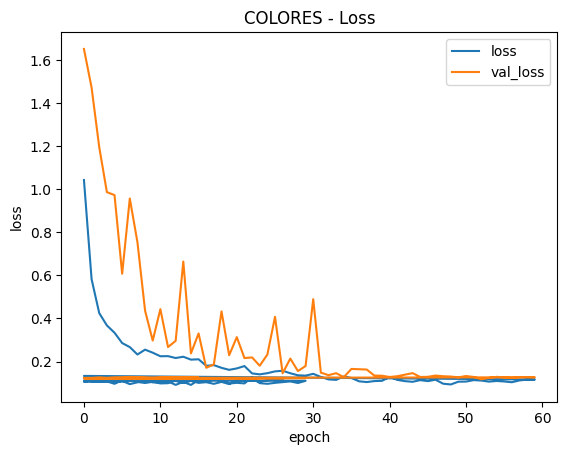

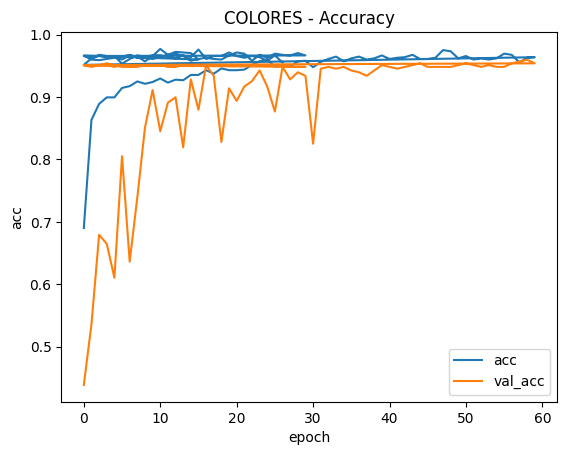

,epoch,accuracy,loss,val_accuracy,val_loss
123,31,0.858672,0.420474,0.818182,0.467872
124,32,0.858672,0.409171,0.805195,0.471297
125,33,0.832976,0.432651,0.805195,0.471184
126,34,0.839400,0.446958,0.805195,0.472317
127,35,0.824411,0.439600,0.805195,0.472758


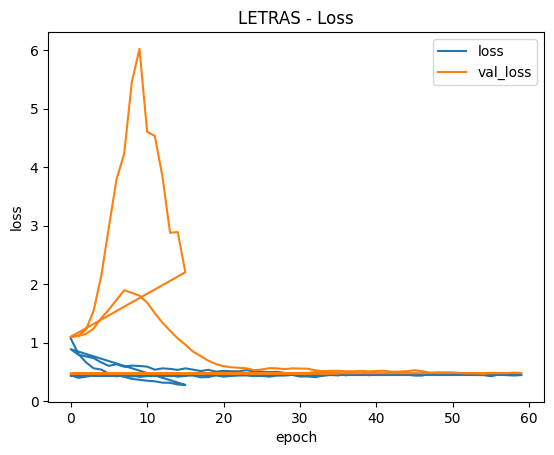

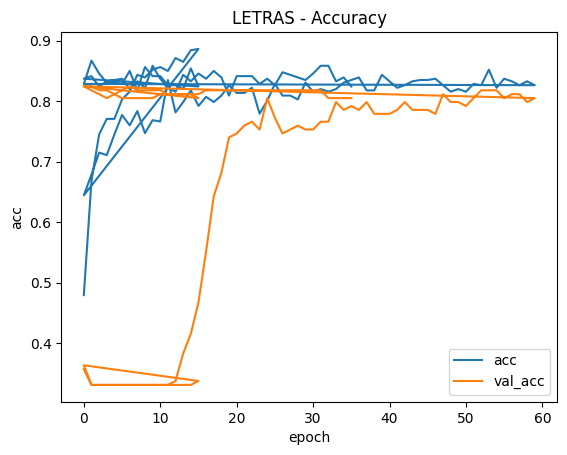

In [ ]:

#BLOQUE 18
import pandas as pd
import matplotlib.pyplot as plt

def plot_logs(csv_path, title="Entrenamiento"):
    if not os.path.exists(csv_path):
        print("No existe:", csv_path); return
    df = pd.read_csv(csv_path)
    display(df.tail())

    # Pérdida
    plt.figure()
    plt.plot(df["epoch"], df["loss"], label="loss")
    if "val_loss" in df: plt.plot(df["epoch"], df["val_loss"], label="val_loss")
    plt.title(title+" - Loss"); plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

    # Accuracy
    if "accuracy" in df:
        plt.figure()
        plt.plot(df["epoch"], df["accuracy"], label="acc")
        if "val_accuracy" in df: plt.plot(df["epoch"], df["val_accuracy"], label="val_acc")
        plt.title(title+" - Accuracy"); plt.legend(); plt.xlabel("epoch"); plt.ylabel("acc"); plt.show()

# Rutas a los CSV que se van acumulando en Drive
LOG_COLORS_CSV  = os.path.join(BK_DIR_COLORS,  "train_log.csv")
LOG_LETTERS_CSV = os.path.join(BK_DIR_LETTERS, "train_log.csv")

plot_logs(LOG_COLORS_CSV,  "COLORES")
plot_logs(LOG_LETTERS_CSV, "LETRAS")

